In [1]:
# 🧩 Assignment 4: ECG Anomaly Detection using Autoencoders
# ==============================================================
# 📘 Step 1: Import Required Libraries
# --------------------------------------------------------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

print("✅ TensorFlow Version:", tf.__version__)


✅ TensorFlow Version: 2.20.0


In [2]:
# 📘 Step 2: Load ECG Dataset
# --------------------------------------------------------------
# Dataset source (provided)
path = "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv"

# Load the dataset into a pandas DataFrame
data = pd.read_csv(path, header=None)
print("✅ Dataset Loaded Successfully!")
print("Shape of dataset:", data.shape)

# Preview first few rows
display(data.head())

✅ Dataset Loaded Successfully!
Shape of dataset: (4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# 📘 Step 3: Data Exploration
# --------------------------------------------------------------
# The last column (index 140) is the Target (0 = Anomaly, 1 = Normal)
# Remaining 140 columns are ECG signal features

print("\nDataset Info:")
print(data.info())

# Split features and target
features = data.drop(140, axis=1)
target = data[140]



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB
None


In [4]:
# ==============================================================
# 📘 Step 4: Train-Test Split
# --------------------------------------------------------------
# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# For Novelty Detection → Train only on "Normal" class (1)
X_train_normal = X_train[y_train == 1]

print(f"Training Samples (Normal only): {X_train_normal.shape}")
print(f"Testing Samples: {X_test.shape}")


Training Samples (Normal only): (2328, 140)
Testing Samples: (1000, 140)


In [5]:
# 📘 Step 5: Normalize Data using MinMaxScaler
# --------------------------------------------------------------
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Scaled between 0 and 1.")


✅ Data Scaled between 0 and 1.


In [6]:
# 📘 Step 6: Define Autoencoder Model
# --------------------------------------------------------------
# Custom Autoencoder class (Encoder + Decoder)
class AutoEncoder(Model):
    def __init__(self, output_units, latent_dim=8):
        super().__init__()
        # Encoder: reduces dimensionality
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(latent_dim, activation='relu')
        ])
        # Decoder: reconstructs the input
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
# 📘 Step 7: Compile the Model
# --------------------------------------------------------------
model = AutoEncoder(output_units=X_train_scaled.shape[1])
model.compile(
    loss='msle',                # Mean Squared Logarithmic Error
    metrics=['mse'],            # Track Mean Squared Error
    optimizer='adam'            # Adam Optimizer
)
print("✅ Model Compiled Successfully!")


✅ Model Compiled Successfully!


In [8]:
# 📘 Step 8: Train the Model
# --------------------------------------------------------------
history = model.fit(
    X_train_scaled,             # Input
    X_train_scaled,             # Target (reconstruction)
    epochs=20,                  # Number of training epochs
    batch_size=512,             # Batch size
    validation_data=(X_test_scaled, X_test_scaled),
    shuffle=True,
    verbose=1
)



Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.0111 - mse: 0.0252 - val_loss: 0.0131 - val_mse: 0.0306
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0109 - mse: 0.0245 - val_loss: 0.0129 - val_mse: 0.0301
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0103 - mse: 0.0234 - val_loss: 0.0125 - val_mse: 0.0292
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0094 - mse: 0.0211 - val_loss: 0.0123 - val_mse: 0.0286
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0082 - mse: 0.0183 - val_loss: 0.0128 - val_mse: 0.0295
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0072 - mse: 0.0161 - val_loss: 0.0121 - val_mse: 0.0279
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0063 - mse: 0.0140 - val_loss: 0.0115 - val_mse: 0.0265
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0056 - mse: 0.0125 - val_loss: 0.0115 - val_mse: 0.0264
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0051 - mse: 0.0114 -

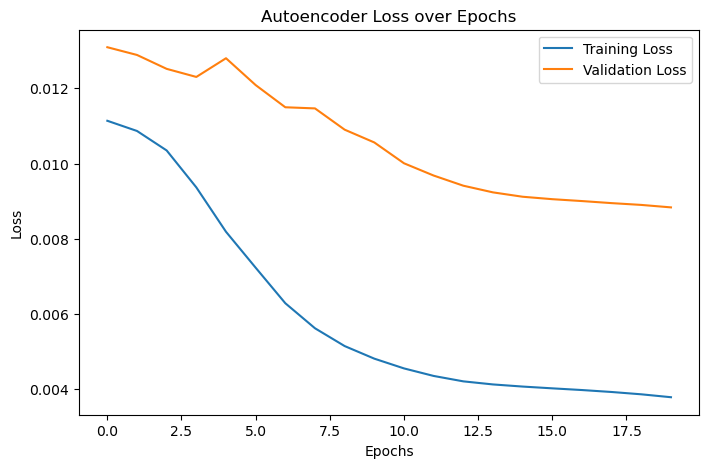

In [9]:
# 📘 Step 9: Plot Training vs Validation Loss
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Autoencoder Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [10]:
# 📘 Step 10: Define Helper Functions
# --------------------------------------------------------------
# Function to calculate threshold based on training reconstruction error
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
    return threshold


# Function to predict anomalies
def get_predictions(model, x_test_scaled, threshold):
    reconstructions = model.predict(x_test_scaled)
    errors = tf.keras.losses.msle(reconstructions, x_test_scaled)
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x else 1.0)  # 0 = anomaly, 1 = normal
    return preds


In [11]:
# ==============================================================
# 📘 Step 11: Detect Anomalies
# --------------------------------------------------------------
threshold = find_threshold(model, X_train_scaled)
print(f"🔍 Calculated Threshold for Anomaly Detection: {threshold:.6f}")

predictions = get_predictions(model, X_test_scaled, threshold)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
🔍 Calculated Threshold for Anomaly Detection: 0.008917
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


✅ Accuracy Score: 0.949


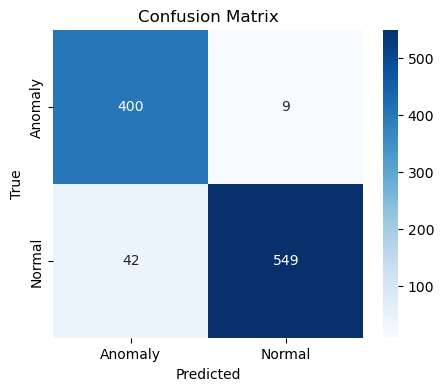

In [13]:
# ==============================================================
# 📘 Step 12: Evaluate the Model
# --------------------------------------------------------------
accuracy = accuracy_score(predictions, y_test)
print(f"✅ Accuracy Score: {accuracy:.3f}")

# Display confusion matrix (optional)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anomaly','Normal'], yticklabels=['Anomaly','Normal'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# ==============================================================
# ✅ Conclusion:
# --------------------------------------------------------------
# - Autoencoder learned to reconstruct normal ECG signals.
# - Higher reconstruction errors indicate anomalies.
# - Accuracy reflects how well anomalies were detected.
# ==============================================================
